In [ ]:
!python -m ipykernel install --user --name=env_cv --display-name "Python (env_cv)"

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import random
from PIL import Image
from torchvision import transforms
import numpy as np
# import cv2

/home/sepidehfatemi/.conda/envs/env_cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
There was a problem when trying to write in your cache folder (/home/jovyan/.cache/huggingface/hub). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.
/home/jovyan/.cache/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /localscratch/2842479/matplotlib-lj_56xpe because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
class ArtDataset(Dataset):
    def __init__(self, df, feature_extractor, train=True):
        self.df = df[df['type'] == ('train' if train else 'test')]
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze()
        label = 1 if row['label'] == 'ai' else 0
        return pixel_values, label

In [4]:
def plot_attention(image_path, model, feature_extractor, device):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Preprocess the image
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    # Get attention scores
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values, output_attentions=True)
        attentions = outputs.attentions  # List of attention maps
        predictions = outputs.logits.argmax(dim=-1).item()  # Get the predicted class

    # Get the last layer's attention scores and average over all heads
    last_layer_attention = attentions[-1]  # Shape: (batch_size, num_heads, seq_len, seq_len)
    avg_attention = last_layer_attention.mean(dim=1).squeeze(0).cpu()  # Average across heads

    # Visualize attention for the [CLS] token
    cls_attention = avg_attention[0, 1:].reshape(14, 14)  # Ignore the CLS token

    # Resize attention to match the image size
    cls_attention_resized = torch.nn.functional.interpolate(
        cls_attention.unsqueeze(0).unsqueeze(0), size=image.size[::-1], mode="bilinear"
    ).squeeze().numpy()

    # Plot the original image and attention
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    ax[1].imshow(image)
    ax[1].imshow(cls_attention_resized, cmap="jet", alpha=0.5)
    ax[1].axis("off")
    ax[1].set_title("Attention Overlay")

    plt.show()

    return predictions

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# Load the model and feature extractor
cache_path = "/home/sepidehfatemi/Projects/CV_final_project/AI-Art-Detection/cache"
checkpoint_path = "./vit_checkpoints/vit_art_classification_final.pth"


model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2, cache_dir=cache_path)

model.load_state_dict(torch.load(checkpoint_path))

model.to(device)

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", cache_dir=cache_path)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/localscratch/2833737/ipykernel_832237/3143770914.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seriali

In [7]:
# load csv
df = pd.read_csv('dataset.csv')
test_df = df[df['type'] == 'test']
train_df = df[df['type'] == 'train']

In [8]:
train_dataset = ArtDataset(df, feature_extractor, train=True)
test_dataset = ArtDataset(df, feature_extractor, train=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=1)
test_df.head()

,image_path,label,style,type
0,data/test/AI_LD_ukiyo-e/9-129255413-960842.jpg,ai,ukiyo_e,test
1,data/test/AI_LD_ukiyo-e/9-106261592-61989.jpg,ai,ukiyo_e,test
2,data/test/AI_LD_ukiyo-e/9-159676882-246126.jpg,ai,ukiyo_e,test
3,data/test/AI_LD_ukiyo-e/9-188568043-886953.jpg,ai,ukiyo_e,test
4,data/test/AI_LD_ukiyo-e/9-216708879-913557.jpg,ai,ukiyo_e,test


In [25]:
file_name = "3-218971924-134721.jpg"
img_index = test_df[test_df["image_path"].str.contains(file_name)].index
img_index

Index([3023], dtype='int64')

True Label: ai


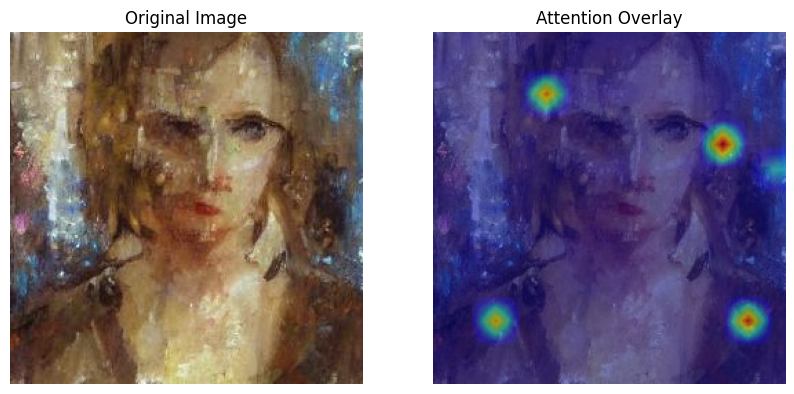

Predicted Label: 1
19308


In [36]:
# i = random.randint(0, len(test_df) - 1)
file_name = "4-22475441-924270.jpg"
img_index = test_df[test_df["image_path"].str.contains(file_name)].index
i = img_index[0]

test_image_path = test_df.iloc[i]['image_path']
true_label = test_df.iloc[i]["label"]
print("True Label:", true_label)

# Plot the attention for the selected image and get the prediction
predicted_label = plot_attention(test_image_path, model, feature_extractor, device)
print("Predicted Label:", predicted_label)
print(i)